In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


In [5]:
n_time = 200
x = np.linspace(0, 2*np.pi, n_time)

# Define three different phases 
# phases = np.array([0, 2*np.pi/3, 4*np.pi/3])
omegas = np.array([1,1,1])

n_genes = 120
cos_values = np.zeros((len(x), n_genes))

# Generate 17 samples for each phase
for i, omega in enumerate(omegas):
    start_idx = i * n_genes//3
    end_idx = start_idx + n_genes//3
    cos_values[:, start_idx:end_idx] = np.cos(x[:, np.newaxis]*omega) 
    # cos_values[:, start_idx:end_idx] = np.cos(x[:, np.newaxis] - phase)

cos_values.shape

(200, 120)

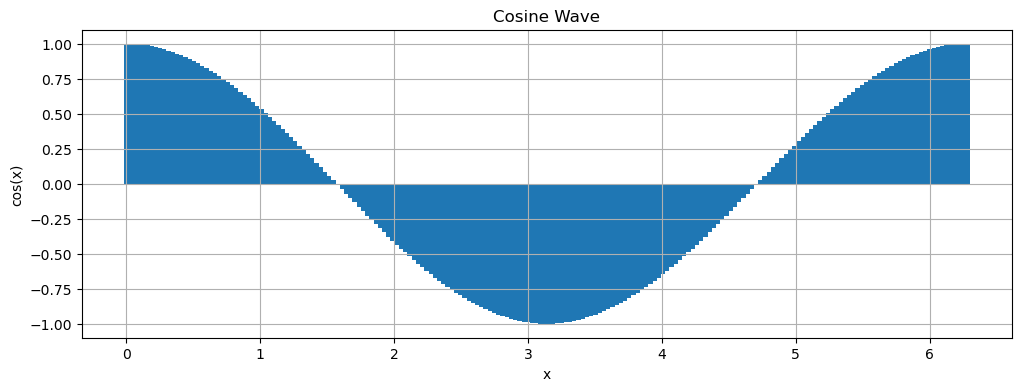

In [9]:
# Plot the cosine wave to visualize the result
plt.figure(figsize=(12, 4))
plt.bar(x, cos_values[:,0], width=x[1]-x[0])
plt.title('Cosine Wave')
plt.xlabel('x')
plt.ylabel('cos(x)')
plt.grid(True)
plt.show()

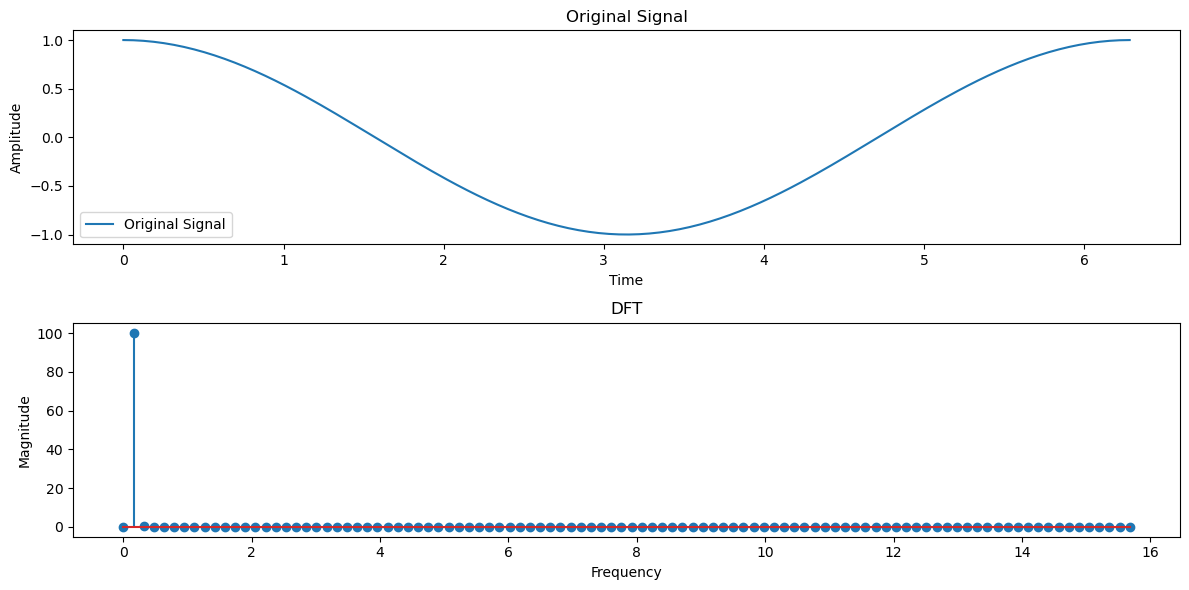

In [11]:
# Compute the DFT
dft = np.fft.rfft(cos_values[:,0]-np.mean(cos_values[:,0]))  # DFT of the signal
frequencies = np.fft.rfftfreq(x.shape[-1],d=x[1]-x[0])  # Frequency bins
# Magnitude of the DFT
magnitude = np.abs(dft)
# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, cos_values[:,0], label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
# Plot the magnitude of the DFT
plt.subplot(2, 1, 2)
plt.stem(frequencies[:n_time//2], magnitude[:n_time//2])
# plt.stem(frequencies[:n_time//2], dft.real[:n_time//2])
# plt.plot(frequencies, dft.real)
plt.title("DFT")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()


In [12]:
# Normalize to get a probability distribution
probabilities = magnitude / np.sum(magnitude)

# Avoid log(0) by adding a small constant (numerical stability)
eps = 1e-12
entropy = -np.sum(probabilities * np.log(probabilities + eps))

print(f"Entropy of the DFT: {entropy.item()}")

Entropy of the DFT: 0.05898755063721788


In [14]:
# Permutate time indexes
np.random.seed(42) 
dataset = np.zeros_like(cos_values)
perm_indices = np.random.permutation(cos_values.shape[0])

# Apply permutation to create new dataset
for i in range(cos_values.shape[0]):
    dataset[i,:] = cos_values[perm_indices[i],:]

print(dataset.shape)


(200, 120)


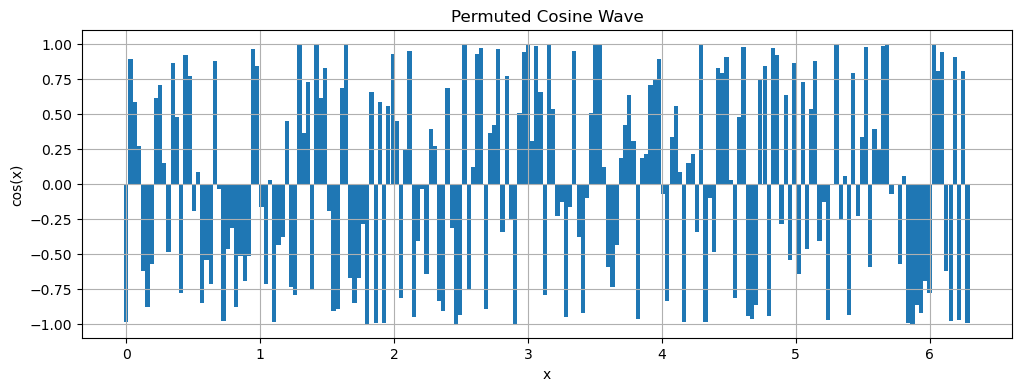

In [15]:
# Plot the cosine wave to visualize the result
plt.figure(figsize=(12, 4))
plt.bar(x, dataset[:,0], width=(2*np.pi/n_time))
plt.title('Permuted Cosine Wave')
plt.xlabel('x')
plt.ylabel('cos(x)')
plt.grid(True)
plt.show()

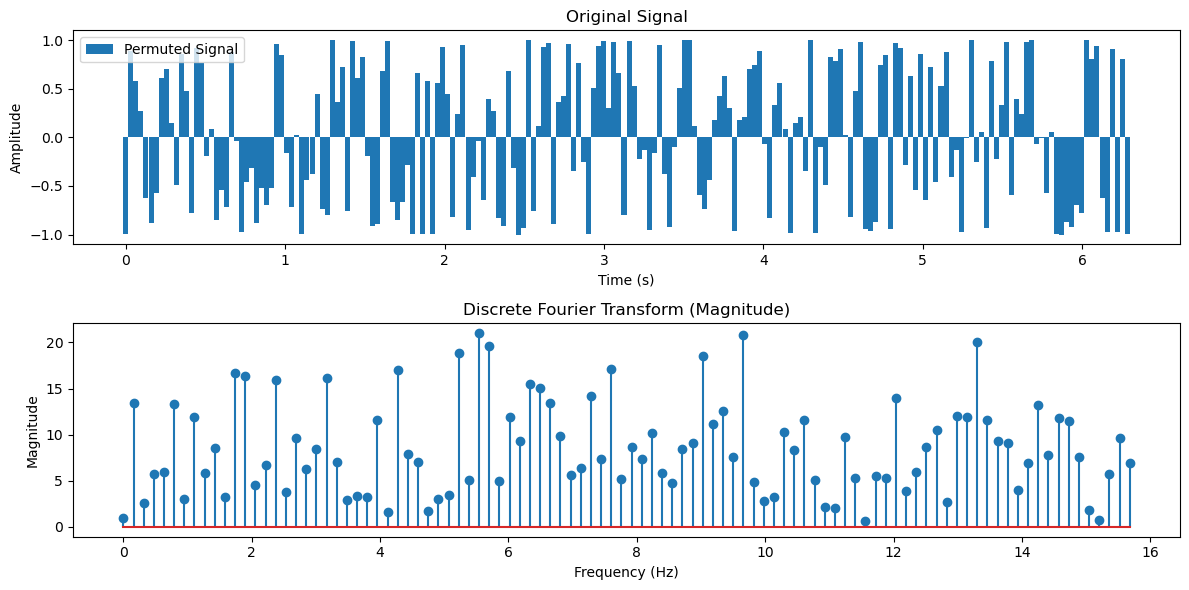

In [18]:
# Compute the DFT
dft = np.fft.rfft(dataset[:,0])  # DFT of the signal
frequencies = np.fft.rfftfreq(len(dataset[:,0]), d=x[1] - x[0])  # Frequency bins
# Magnitude of the DFT
magnitude = np.abs(dft)
# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.bar(x, dataset[:,0], width=(2*np.pi/n_time),label="Permuted Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
# Plot the magnitude of the DFT
plt.subplot(2, 1, 2)
plt.stem(frequencies[:n_time//2], magnitude[:n_time//2])
plt.title("Discrete Fourier Transform (Magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

In [19]:
# Normalize to get a probability distribution
probabilities = magnitude / np.sum(magnitude)
# Avoid log(0) by adding a small constant (numerical stability)
eps = 1e-12
entropy = -np.sum(probabilities * np.log(probabilities + eps))

print(f"Entropy of the DFT: {entropy.item()}")

Entropy of the DFT: 4.440898650547752


In [20]:
# Convert to torch
dataset_torch = torch.tensor(dataset, dtype=torch.float32) 
dataset_torch.shape

torch.Size([200, 120])

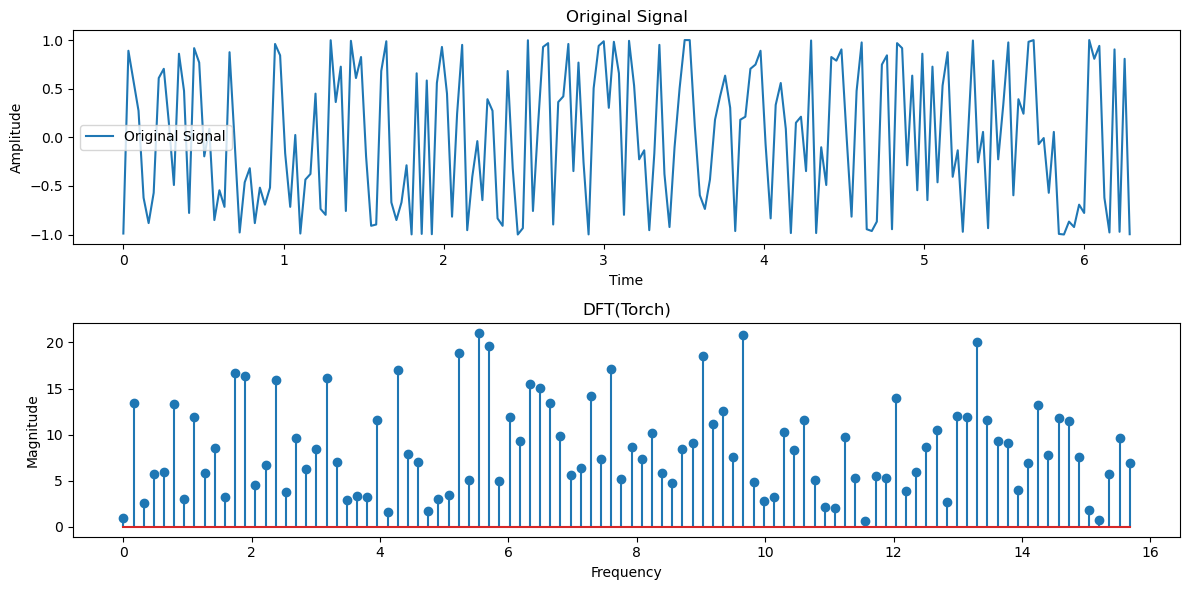

In [21]:
# Test torch DFT
dft = torch.fft.rfft(dataset_torch[:,0])  # Forward Fourier Transform
frequencies = torch.fft.rfftfreq(n_time, d=(x[1] - x[0]).item())  # Frequency bins
magnitude = torch.abs(dft)

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, dataset_torch[:,0].numpy(), label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

# Plot the magnitude of the DFT
plt.subplot(2, 1, 2)
plt.stem(frequencies[:n_time//2].numpy(), magnitude[:n_time//2].numpy())
plt.title("DFT(Torch)")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

In [22]:
# Normalize to get a probability distribution
probabilities = magnitude / torch.sum(magnitude)

# Avoid log(0) by adding a small constant (numerical stability)
eps = 1e-12
entropy = -torch.sum(probabilities * torch.log(probabilities + eps))

print(f"Entropy of the DFT: {entropy.item()}")

Entropy of the DFT: 4.440898418426514


In [23]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 50), 
            nn.ReLU(),
            nn.Linear(50, 20), 
            nn.ReLU(),
            nn.Linear(20, 1)   
        )

        self.decoder = nn.Sequential(
            nn.Linear(1, 20),    
            nn.ReLU(),
            nn.Linear(20, 50),  
            nn.ReLU(),
            nn.Linear(50, input_dim)
            # nn.Sigmoid()         
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

In [26]:
def reorder_by_pseudotime(dataset, latent_values):
    order = torch.argsort(latent_values.squeeze())  
    return dataset[order]

def compute_entropy(dft):
    magnitude = torch.abs(dft)
    probabilities = magnitude / torch.sum(magnitude)
    
    eps = 1e-12
    entropy = -torch.sum(probabilities * torch.log(probabilities + eps))
    return entropy

In [27]:
def entropy_loss(dataset, latent_order):
    order = torch.argsort(latent_order.squeeze())
    reordered_dataset = dataset[order]
    dft = torch.fft.rfft(reordered_dataset)
    
    magnitude = torch.abs(dft)
    probabilities = magnitude / torch.sum(magnitude)
    eps = 1e-12
    entropy = -torch.sum(probabilities * torch.log(probabilities + eps))
    return entropy

In [33]:
autoencoder = Autoencoder(input_dim=dataset_torch.shape[1])
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 1000

for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    latent_values, reconstructed = autoencoder(dataset_torch)
    # reordered_dataset = reorder_by_pseudotime(dataset_torch, latent_values) 

    # dft = torch.fft.rfft(reordered_dataset)
    # entropy = compute_entropy(dft)

    total_loss = nn.MSELoss()(reconstructed, dataset_torch) + entropy_loss(dataset_torch,latent_values)
    
    total_loss.backward()
    optimizer.step()
    entropy = entropy_loss(dataset_torch,latent_values)
    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Total Loss: {total_loss.item():.4f}, Entropy Loss: {entropy.item():2f}")


Epoch [0/1000], Total Loss: 5.6836, Entropy Loss: 5.154098
Epoch [50/1000], Total Loss: 5.2086, Entropy Loss: 5.154098
Epoch [100/1000], Total Loss: 5.1566, Entropy Loss: 5.154098
Epoch [150/1000], Total Loss: 5.1552, Entropy Loss: 5.154098
Epoch [200/1000], Total Loss: 5.1547, Entropy Loss: 5.154098
Epoch [250/1000], Total Loss: 5.1545, Entropy Loss: 5.154098
Epoch [300/1000], Total Loss: 5.1543, Entropy Loss: 5.154098
Epoch [350/1000], Total Loss: 5.1543, Entropy Loss: 5.154098
Epoch [400/1000], Total Loss: 5.1542, Entropy Loss: 5.154098
Epoch [450/1000], Total Loss: 5.1542, Entropy Loss: 5.154098
Epoch [500/1000], Total Loss: 5.1542, Entropy Loss: 5.154098
Epoch [550/1000], Total Loss: 5.1542, Entropy Loss: 5.154098
Epoch [600/1000], Total Loss: 5.1542, Entropy Loss: 5.154098
Epoch [650/1000], Total Loss: 5.1542, Entropy Loss: 5.154098
Epoch [700/1000], Total Loss: 5.1541, Entropy Loss: 5.154098
Epoch [750/1000], Total Loss: 5.1541, Entropy Loss: 5.154098
Epoch [800/1000], Total Los

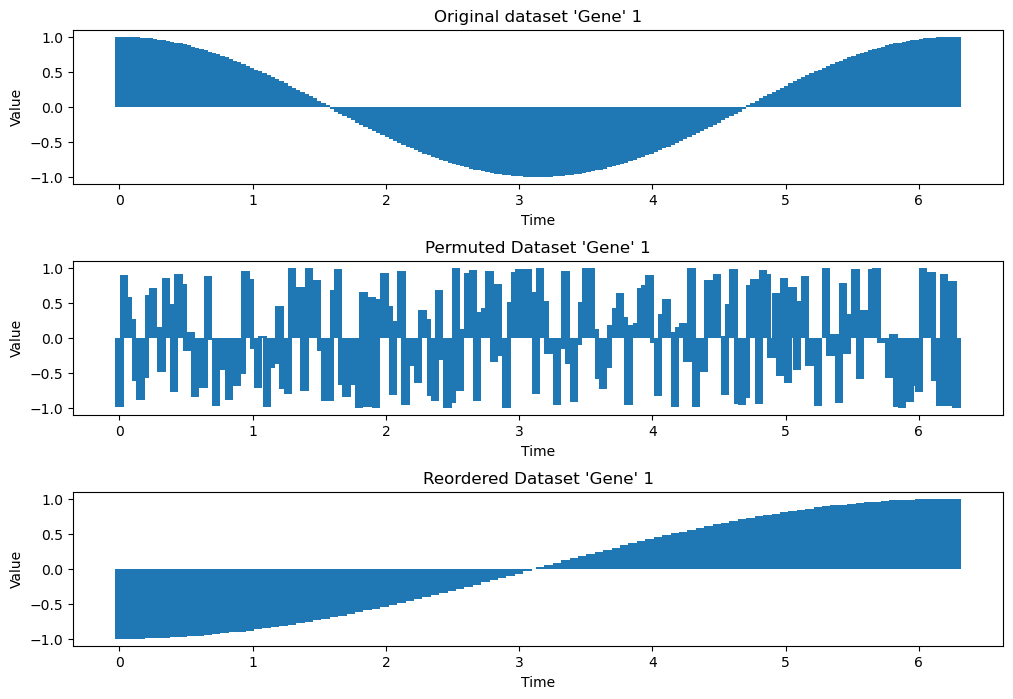

In [34]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.bar(x, cos_values[:,0], width=(2*np.pi/100))
plt.title("Original dataset 'Gene' 1")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(3, 1, 2)
plt.bar(x, dataset[:,0], width=(2*np.pi/100))
plt.title("Permuted Dataset 'Gene' 1")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(3, 1, 3)
reordered_dataset = dataset_torch[torch.argsort(latent_values.squeeze())]
reordered_dataset_np = reordered_dataset.detach().numpy()
plt.bar(x, reordered_dataset_np[:,0], width=(2*np.pi/100))
plt.title("Reordered Dataset 'Gene' 1")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing between subplots
plt.show()

Entropy: 3.6369009017944336


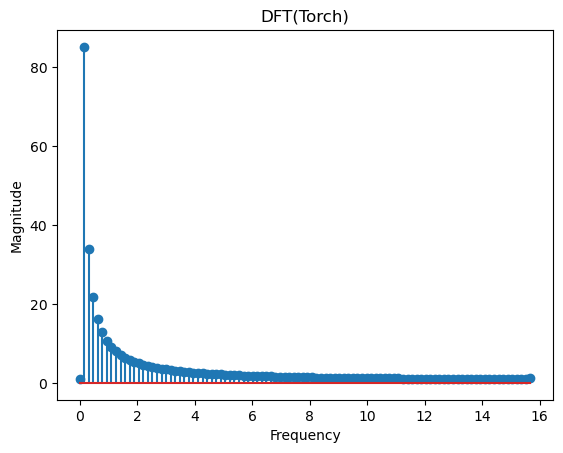

In [35]:
dft = torch.fft.rfft(reordered_dataset[:,0])
magnitude = torch.abs(dft)
frequencies = torch.fft.rfftfreq(n_time, d=(x[1] - x[0]).item())

probabilities = magnitude / torch.sum(magnitude)
entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-12))

print(f"Entropy: {entropy}")

plt.stem(frequencies[:n_time//2].numpy(), magnitude[:n_time//2].numpy())
plt.title("DFT(Torch)")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
y = sin(w*x)
w*x = arcsin(y)
x = arcsin(y)/w

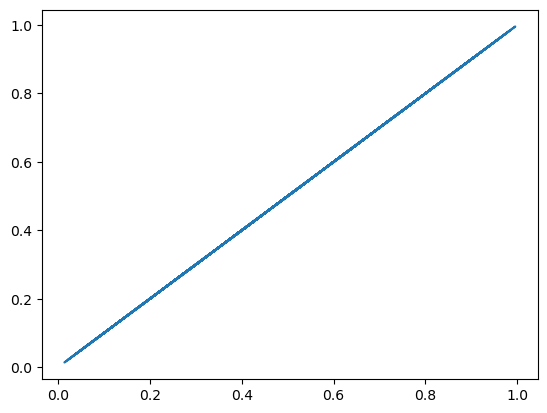

In [418]:
_xx = np.linspace(0, 2*np.pi)
_yy = np.sin(_xx) + np.sin(1.5*_xx) #+ np.cos(2.5*_xx)

_yy = np.random.rand(100)

_oo = _yy.argsort()

plt.plot(_yy, _yy)

# fig, axs = plt.subplots(2, 1)
# axs[1].plot(np.arcsin(_yy), _yy, '.')
# axs[0].hist(np.arcsin(_yy))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


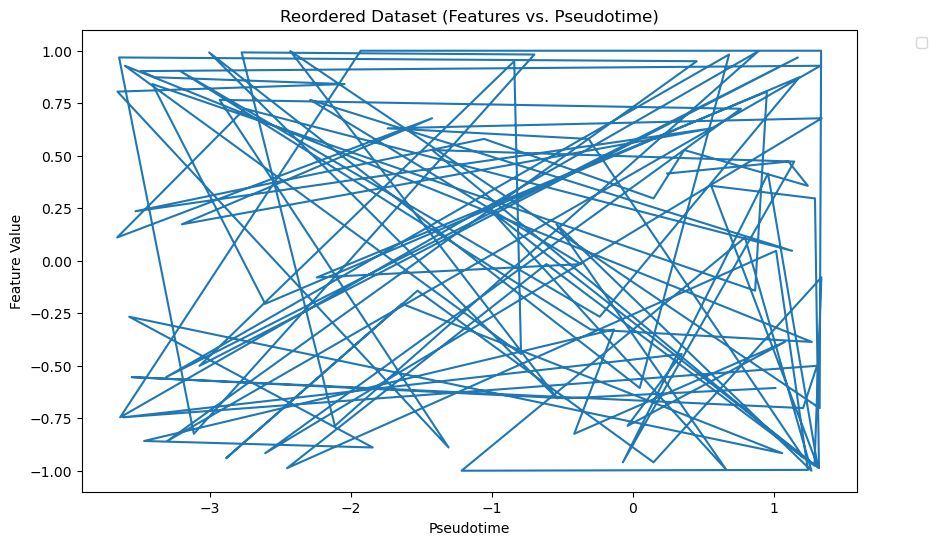

In [207]:
# Assuming `reordered_dataset` is your dataset reordered based on pseudotime
# If the original dataset has shape (100, 51), you can plot each feature over pseudotime

reordered_dataset = reordered_dataset.detach().numpy()  # Convert to numpy array for visualization

# Plot the features of the reordered dataset over pseudotime
plt.figure(figsize=(10, 6))
# for i in range(reordered_dataset.shape[1]):  # Loop over each feature
plt.plot(latent_values, reordered_dataset[:, 0])
plt.xlabel("Pseudotime")
plt.ylabel("Feature Value")
plt.title("Reordered Dataset (Features vs. Pseudotime)")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()
